In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = ""



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from dcmnet.rdkit_utils import get_mol_from_id



devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [3]:
import rdkit
from rdkit.Chem import Draw

In [4]:
datadir = Path("/pchem-data/meuwly/boittier/home/jaxeq/")

In [5]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    # 126907,
    6907,
    [
        # datadir / "data/qm9-esp-dip-40000-0.npz", 
        # datadir / "data/qm9-esp-dip-40000-1.npz", 
        # datadir / "data/qm9-esp-dip-40000-2.npz", 
        datadir / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [13]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [165]:
import ase.data

In [166]:
def batch_to_xyzblock(batch):
    block = ""
    xyz_str = ""
    count = 0
    for elem, xyz in zip(batch["Z"], batch["R"]):
        if elem != 0:
            count+=1
            xyz_str += "{} {}\n".format(ase.data.chemical_symbols[elem], " ".join([f"{_:.3f}" for _ in xyz]))
    block += f"{count}\n\n"
    block += xyz_str
    return block

In [167]:
# https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDetermineBonds
def xyz_to_pdb_block(xyz_block):
    pdb_block = ''
    n = 0
    n_atoms = 0
    with StringIO(xyz_block) as hnd:
        while True:
            line = hnd.readline()
            if (not line):
                raise RuntimeError('XYZ block ended prematurely')
            n += 1
            if (n == 1):
                try:
                    n_atoms = int(line.strip())
                except Exception as e:
                    raise type(e)('Could not parse number of atoms on line {0:d}'.format(n)) from e
            elif (n > 2):
                try:
                    elem, x, y, z = line.strip().split()
                except Exception as e:
                    raise type(e)('Could not parse coordinate line {0:d}'.format(n)) from e
                pdb_block += 'ATOM  {0:5d} {1:>2s}   UNL     1    {2:8.3f}{3:8.3f}{4:8.3f}  1.00  0.00\n'.format(
                    n - 2, elem, float(x), float(y), float(z))
                if (n == n_atoms + 2):
                    break
    return pdb_block   

import py3Dmol
def draw_with_spheres(mol):
    v = py3Dmol.view(width=300,height=300)
    IPythonConsole.addMolToView(mol,v)
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
    v.show()

In [168]:
block = batch_to_xyzblock(batch)

In [172]:
relax_fails = []
gdb_fails = []

for i in range(len(valid_batches)):
    batch = valid_batches[i]
    fn = str(batch["id"][0])
    block = batch_to_xyzblock(batch)
    mols = get_mol_from_id(batch)
    m0 = mols[0]
    
    try:
        smi = Chem.CanonSmiles(Chem.MolToSmiles(m0))
    except:
        smi = None
        continue
        
    mol = Chem.MolFromXYZBlock(block)
    if mol is None:
        print(f'Could not parse {fn}')
        continue
    try:
        rdDetermineBonds.DetermineBonds(mol,charge=0)
    except:
        continue
    # remove double bond stereo:
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond.SetStereo(Chem.BondStereo.STEREONONE)
        elif bond.GetBondType() == Chem.BondType.SINGLE:
            bond.SetBondDir(Chem.BondDir.NONE)
    osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
    # compare to relax_smi:
    # print(smi, osmi)
    if smi!=osmi:
        relax_fails.append((fn,smi,osmi))
        gdb_smi=smi
        # that failed, so next we are going to compare to gdb_smi;
        try:
            smi = Chem.CanonSmiles(gdb_smi)
        except:
            continue
        # the GDB smiles don't have any stereo at all, so get rid of atomic stereo
        for atom in mol.GetAtoms():
            atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
        if smi != osmi:
            gdb_fails.append((fn,smi,osmi))
        

Atoms:
	0 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	1 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	2 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	3 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	4 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	5 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	6 6 C chg: 0  deg: 4 exp: N/A imp: 0 hyb: 
	7 6 C chg: -1  deg: 3 exp: N/A imp: 0 hyb: 
	8 7 N chg: -1  deg: 2 exp: N/A imp: 0 hyb: 
	9 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	10 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	11 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	12 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	13 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	14 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	15 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	16 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
	17 1 H chg: 0  deg: 1 exp: N/A imp: 0 hyb: 
Bonds:
	0 1->0 order: 1
	1 2->1 order: 1
	2 3->2 order: 1
	3 4->3 order: 1
	4 5->4 order: 1
	5 6->5 order: 1
	6 6->1 order: 1
	7 7->6 order: 1
	8 7->3 order: 1
	9 7->1 order: 1
	10 8->5 order

In [173]:
gdb_fails

[('dsgdb9nsd_121896', 'COCCC([NH3+])C(=O)[O-]', 'COCCC(N)C(=O)O'),
 ('dsgdb9nsd_060635', '[NH3+]C1CC1C(O)C(=O)[O-]', 'NC1CC1C(O)C(=O)O'),
 ('dsgdb9nsd_098239', 'CNC(=O)C([NH3+])C(=O)[O-]', 'CNC(=O)C(N)C(=O)O'),
 ('dsgdb9nsd_005598', '[NH3+]Cc1ccoc1[O-]', 'NCc1ccoc1O'),
 ('dsgdb9nsd_102795', 'N=COC(C[NH3+])C(=O)[O-]', 'NCC1OC(N)OC1=O'),
 ('dsgdb9nsd_060429', 'CC(C)[NH2+]CCC(=O)[O-]', 'CC(C)NCCC(=O)O'),
 ('dsgdb9nsd_022265', 'CC(=N[O-])C1(O)C[NH2+]C1', 'CC(=[NH+][O-])C1(O)CNC1'),
 ('dsgdb9nsd_006792', '[NH3+]CCOCC(=O)[O-]', 'NCCOCC(=O)O'),
 ('dsgdb9nsd_086827', '[NH3+]C1CC(CC(=O)[O-])C1', 'NC1CC(CC(=O)O)C1'),
 ('dsgdb9nsd_127895', 'CN=c1nnoc(O)n1', 'CN=C=NC(=O)O.N#N'),
 ('dsgdb9nsd_113165', 'CCC1CC1([NH3+])C(=O)[O-]', 'CCC1CC1(N)C(=O)O'),
 ('dsgdb9nsd_054179', 'CC1(C(=O)[O-])CN1C=[NH2+]', 'CC12CN1C(N)OC2=O'),
 ('dsgdb9nsd_101926', 'C[NH2+]C(C(=O)[O-])C1CN1', 'CNC(C(=O)O)C1CN1'),
 ('dsgdb9nsd_037993', 'C1=C2CC3N=C1N1C2C31', 'C=C1C=C2N=CC3C1N23'),
 ('dsgdb9nsd_130402', 'N#Cc1[n-]nnc1C[NH3+

In [180]:
len(relax_fails)

85151

In [175]:
df = pd.read_csv("/pchem-data/meuwly/boittier/home/jaxeq/data/qm9.csv")
df

,Unnamed: 0.1,Unnamed: 0,inchi,smiles,rotational_constant_a,rotational_constant_b,rotational_constant_c,dipole_moment,polarizability,homo,lumo,gap,r2,zero_point_energy,u0,u298,h298,g298,heat_capacity
0,0,0,InChI=1S/CH4/h1H4,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,1,1,InChI=1S/H3N/h1H3,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316
2,2,2,InChI=1S/H2O/h1H2,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002
3,3,3,InChI=1S/C2H2/c1-2/h1-2H,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574
4,4,4,InChI=1S/CHN/c1-2/h1H,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,133880,133880,"InChI=1S/C7H7NO/c1-2-4-3-5-6(8(2)4)7(1,3)9-5/h...",C1C2C3C4C5OC14C5N23,3.59483,2.198990,1.904230,1.6637,69.37,-0.2254,0.0588,0.2842,760.7472,0.127406,-400.633868,-400.628599,-400.627654,-400.663098,23.658
133881,133881,133881,InChI=1S/C7H7NO/c1-7-2-4-5(8(1)4)3(7)6(2)9-7/h...,C1N2C3C2C2C4OC12C34,3.65648,2.142370,1.904390,1.2976,69.52,-0.2393,0.0608,0.3002,762.6354,0.127495,-400.629713,-400.624444,-400.623500,-400.658942,23.697
133882,133882,133882,InChI=1S/C7H8N2/c1-7-2-9-5(7)3-4(6(7)9)8(1)3/h...,C1N2C3C4C5C2C13CN45,3.67118,2.143140,1.895010,1.2480,73.60,-0.2233,0.0720,0.2953,780.3553,0.140458,-380.753918,-380.748619,-380.747675,-380.783148,23.972
133883,133883,133883,InChI=1S/C8H9N/c1-3-4-5(3)7-8(1)2-9(7)6(4)8/h3...,C1N2C3C4C5CC13C2C45,3.52845,2.151310,1.865820,1.9576,77.40,-0.2122,0.0881,0.3003,803.1904,0.152222,-364.720374,-364.714974,-364.714030,-364.749650,24.796


In [176]:
pd.DataFrame(gdb_fails).to_csv("qm9-fails.csv", index=False)

In [177]:
fails = []
for i in range(len(gdb_fails)):
    fails.append(Chem.MolFromSmiles(gdb_fails[i][1]))
    fails.append(Chem.MolFromSmiles(gdb_fails[i][2]))


In [178]:
len(fails) // 2

1711

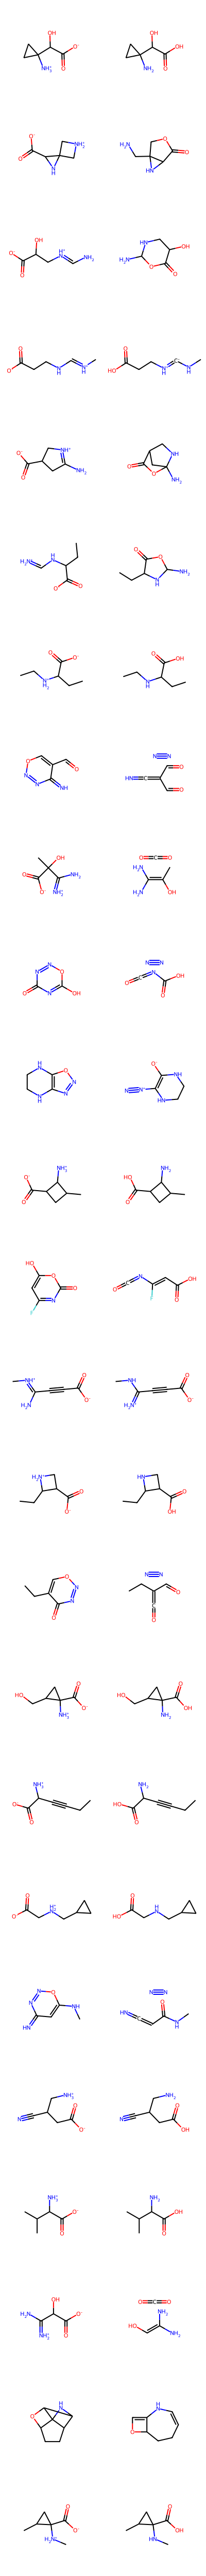

In [182]:
Draw.MolsToGridImage(fails[400:], molsPerRow=2)